In [1]:
import json

import gc_utils
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import gridspec
from matplotlib.legend_handler import HandlerTuple

In [2]:
sim = "m12b"
sim_dir = "/Users/z5114326/Documents/simulations/"

ghost_file = sim_dir + sim + "/" + sim + "_ghosts.hdf5"
ghost_data = h5py.File(ghost_file, "r")  # open processed data file

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

pub_data = sim_dir + "/snapshot_times_public.txt"
pub_snaps = pd.read_table(pub_data, comment="#", header=None, sep=r"\s+")
pub_snaps.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]
snp_lst = pub_snaps["index"].values
tim_lst = pub_snaps["time_Gyr"].values

grp_file = sim_dir + sim + "/" + "gc_groups.json"
with open(grp_file, "r") as file:
    grp_dict = json.load(file)

grp_lst = [int(grp) for grp in grp_dict[sim]]

In [3]:
n_lst = []
mass_lst = []
n_surv_lst = []

for it_id in ghost_data.keys():
    src_dat = ghost_data[it_id]["source"]
    mass = 10 ** src_dat["logm_tfor"][()]
    mass_lst.append(np.average(mass))
    # mass_lst.append(np.sum(mass))
    n_lst.append(len(mass))

    snp_dat = ghost_data[it_id]["snapshots"]["snap600"]
    n_surv_lst.append(len(snp_dat["gcid"][()]))

n_lst = np.array(n_lst)
mass_lst = np.array(mass_lst)
n_surv_lst = np.array(n_surv_lst)

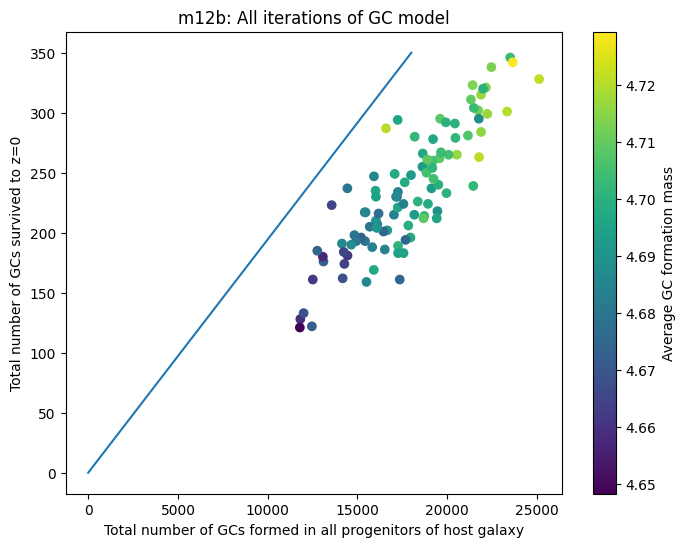

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(n_lst, n_surv_lst, c=np.log10(mass_lst))
plt.colorbar(label="Average GC formation mass")
# plt.xscale("log")
# plt.yscale("log")

plt.xlabel("Total number of GCs formed in all progenitors of host galaxy")
plt.ylabel("Total number of GCs survived to z=0")

plt.title(sim + ": All iterations of GC model")

plt.plot([0, 18000], [0, 350])

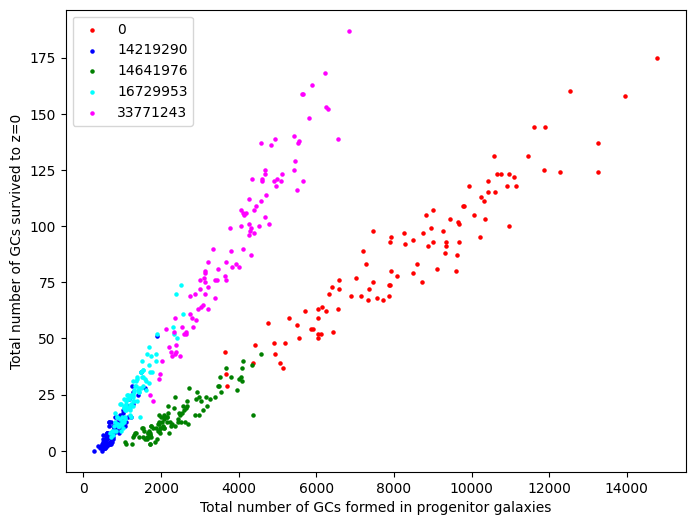

In [5]:
data_dict = {grp: {"all": [], "z0": []} for grp in grp_lst}

for it_id in ghost_data.keys():
    src_dat = ghost_data[it_id]["source"]
    for grp in grp_lst:
        # if grp == 0:
        #     continue
        gmsk = np.abs(src_dat["grpid"][()]) == grp
        smsk = src_dat["s_flag"][()] == 1

        data_dict[grp]["all"].append(np.sum(gmsk))
        data_dict[grp]["z0"].append(np.sum(gmsk & smsk))

plt.figure(figsize=(8, 6))
for grp in grp_lst:
    x = data_dict[grp]["all"]
    y = data_dict[grp]["z0"]
    c = grp_dict[sim][str(grp)]
    plt.scatter(x, y, c=c, s=5, label=grp)

# plt.xscale("log")
# plt.yscale("log")

plt.xlabel("Total number of GCs formed in progenitor galaxies")
plt.ylabel("Total number of GCs survived to z=0")
plt.legend()

# Linear relation implies a fixed survival fraction for each accretion event / galaxy
# What impact survival fraction (different galaxies have different survival fraction)

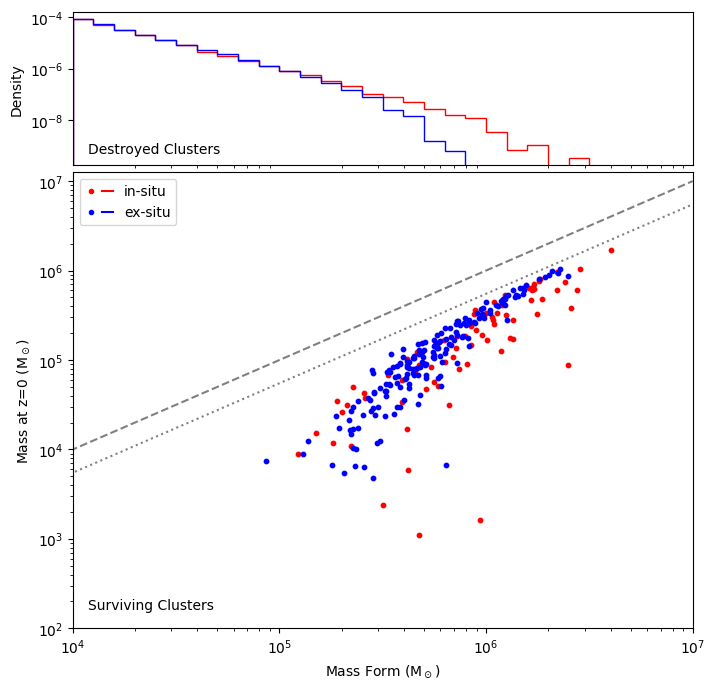

In [6]:
it = 0
it_id = gc_utils.iteration_name(it)

src_dat = ghost_data[it_id]["source"]

m_fo = 10 ** src_dat["logm_tfor"][()]
m_z0 = 10 ** src_dat["logm_tz0"][()]

s_msk = src_dat["s_flag"][()] == 1
grp_msk = src_dat["grpid"][()] == 0

m_fo_in = m_fo[s_msk & grp_msk]
m_z0_in = m_z0[s_msk & grp_msk]

m_fo_ex = m_fo[s_msk & ~grp_msk]
m_z0_ex = m_z0[s_msk & ~grp_msk]

m_fo_in_d = m_fo[~s_msk & grp_msk]
m_fo_ex_d = m_fo[~s_msk & ~grp_msk]

fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
plt.subplots_adjust(hspace=0.025)

bins = bins = np.logspace(4, 7, 31)
ax0.hist(m_fo_in_d, bins=bins, histtype="step", color="r", density=True)
ax0.hist(m_fo_ex_d, bins=bins, histtype="step", color="b", density=True)

ax1.scatter(m_fo_in, m_z0_in, c="r", s=10)
ax1.scatter(m_fo_ex, m_z0_ex, c="b", s=10)

ax0.set_xscale("log")
ax1.set_xscale("log")
ax0.set_yscale("log")
ax1.set_yscale("log")

x_lin = np.array([10**2, 10**7])
y_lin = x_lin

ax1.plot(x_lin, y_lin, c="grey", ls="--")
ax1.plot(x_lin, 0.55 * y_lin, c="grey", ls="dotted")

ax0.set_xlim(10**4, 10**7)
ax1.set_xlim(10**4, 10**7)

ax0.set_xticks([])

ax1.set_ylim(10**2, 10**7.1)

ax1.set_xlabel(r"Mass Form (M$_\odot$)")
ax1.set_ylabel(r"Mass at z=0 (M$_\odot$)")
ax0.set_ylabel(r"Density")

ax0.text(0.025, 0.1, "Destroyed Clusters", transform=ax0.transAxes, ha="left", va="center")
ax1.text(0.025, 0.05, "Surviving Clusters", transform=ax1.transAxes, ha="left", va="center")

indot = plt.Line2D([], [], color="r", marker=".", linestyle="None", markersize=6)
inlin = plt.Line2D([], [], color="r", linestyle="-", lw=1.5)
exdot = plt.Line2D([], [], color="b", marker=".", linestyle="None", markersize=6)
exlin = plt.Line2D([], [], color="b", linestyle="-", lw=1.5)

plt.legend(
    [(indot, inlin), (exdot, exlin)],
    ["in-situ", "ex-situ"],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=10,
)


Text(0, 0.5, 'Mass at z=0 (M$_\\odot$)')

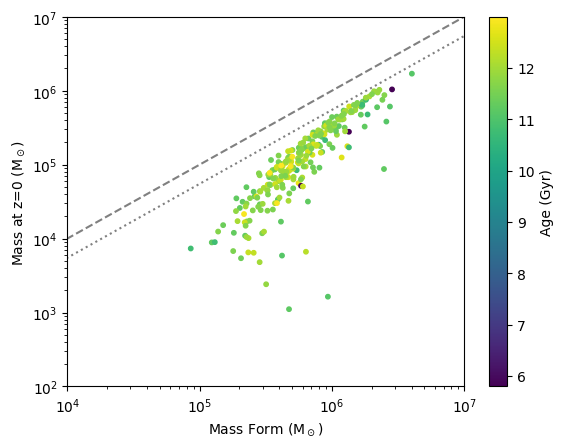

In [360]:
it = 0
it_id = gc_utils.iteration_name(it)

src_dat = ghost_data[it_id]["source"]

m_fo = 10 ** src_dat["logm_tfor"][()]
m_z0 = 10 ** src_dat["logm_tz0"][()]
c = 13.798746883 - src_dat["tfor"][()]

s_msk = src_dat["s_flag"][()] == 1

plt.scatter(m_fo[s_msk], m_z0[s_msk], c=c[s_msk], s=10)
plt.colorbar(label="Age (Gyr)")

plt.xscale("log")
plt.yscale("log")

x_lin = np.array([10**2, 10**7])
y_lin = x_lin

plt.plot(x_lin, y_lin, c="grey", ls="--")
plt.plot(x_lin, 0.55 * y_lin, c="grey", ls="dotted")

plt.xlim(10**4, 10**7)
plt.ylim(10**2, 10**7)

plt.xlabel(r"Mass Form (M$_\odot$)")
plt.ylabel(r"Mass at z=0 (M$_\odot$)")

Text(0, 0.5, 'Mass at z=0 (M$_\\odot$)')

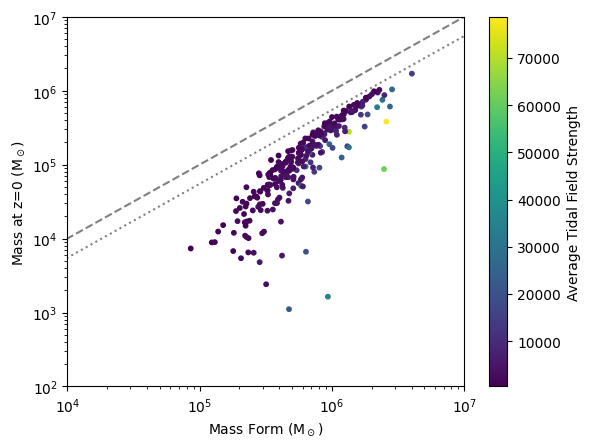

In [361]:
it = 0
it_id = gc_utils.iteration_name(it)

src_dat = ghost_data[it_id]["source"]

m_fo = 10 ** src_dat["logm_tfor"][()]
m_z0 = 10 ** src_dat["logm_tz0"][()]
c = src_dat["tideig.avg"][()]

s_msk = src_dat["s_flag"][()] == 1

plt.scatter(m_fo[s_msk], m_z0[s_msk], c=c[s_msk], s=10)
plt.colorbar(label="Average Tidal Field Strength")

plt.xscale("log")
plt.yscale("log")

x_lin = np.array([10**2, 10**7])
y_lin = x_lin

plt.plot(x_lin, y_lin, c="grey", ls="--")
plt.plot(x_lin, 0.55 * y_lin, c="grey", ls="dotted")

plt.xlim(10**4, 10**7)
plt.ylim(10**2, 10**7)

plt.xlabel(r"Mass Form (M$_\odot$)")
plt.ylabel(r"Mass at z=0 (M$_\odot$)")

In [362]:
# search for a gcid that survives in one iteration and dies in another

# --- Collect all unique GCIDs ---
gcid_full = np.unique(
    np.concatenate([ghost_data[it_id]["source"]["gcid"][()] for it_id in ghost_data.keys()])
)

# --- Preallocate dictionary ---
gcid_dict = {gcid: {"s": [], "d": [], "n": []} for gcid in gcid_full}

# --- Reverse the loop order: iterate over iterations, not gcids ---
for it_id, it_data in ghost_data.items():
    src_dat = it_data["source"]
    gcids = src_dat["gcid"][()]
    s_flag = src_dat["s_flag"][()] == 1

    gcid_s = set(gcids[s_flag])
    gcid_d = set(gcids[~s_flag])
    gcid_all = set(gcids)

    for gcid in gcid_s:
        gcid_dict[gcid]["s"].append(it_id)
    for gcid in gcid_d:
        gcid_dict[gcid]["d"].append(it_id)
    # For gcids not present in this iteration
    for gcid in gcid_full:
        if gcid not in gcid_all:
            gcid_dict[gcid]["n"].append(it_id)

In [363]:
gcid_lst = []

len_lim = 5
for gcid in gcid_dict.keys():
    s_len = len(gcid_dict[gcid]["s"])
    d_len = len(gcid_dict[gcid]["d"])

    if (s_len >= len_lim) & (d_len >= len_lim):
        gcid_lst.append(gcid)

len(gcid_lst)

348

In [364]:
smass_min = []
dmass_max = []
for gcid in gcid_lst:
    smass = []
    dmass = []
    for it_id in gcid_dict[gcid]["s"]:
        src_dat = ghost_data[it_id]["source"]
        gcidx = np.where(src_dat["gcid"][()] == gcid)[0][0]
        smass.append(10 ** src_dat["logm_tfor"][gcidx])

    for it_id in gcid_dict[gcid]["d"]:
        src_dat = ghost_data[it_id]["source"]
        gcidx = np.where(src_dat["gcid"][()] == gcid)[0][0]
        dmass.append(10 ** src_dat["logm_tfor"][gcidx])

    smass_min.append(np.min(smass))
    dmass_max.append(np.max(dmass))

Text(0, 0.5, 'Maximum Disrupted Formation Mass (M$_\\odot$)')

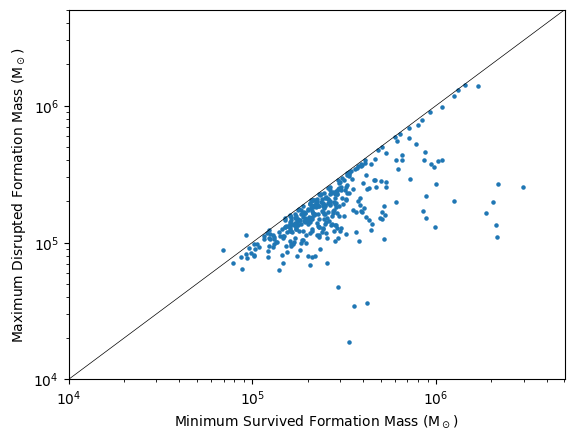

In [365]:
plt.scatter(smass_min, dmass_max, s=5)

plt.xscale("log")
plt.yscale("log")

plt.plot([0, 10**7], [0, 10**7], c="k", lw=0.5)

plt.xlim(10**4, 10**6.7)
plt.ylim(10**4, 10**6.7)

plt.xlabel(r"Minimum Survived Formation Mass (M$_\odot$)")
plt.ylabel(r"Maximum Disrupted Formation Mass (M$_\odot$)")

In [366]:
np.where(np.array(smass_min) < np.array(dmass_max))[0]

array([106, 234])

(4.967, 5.056)

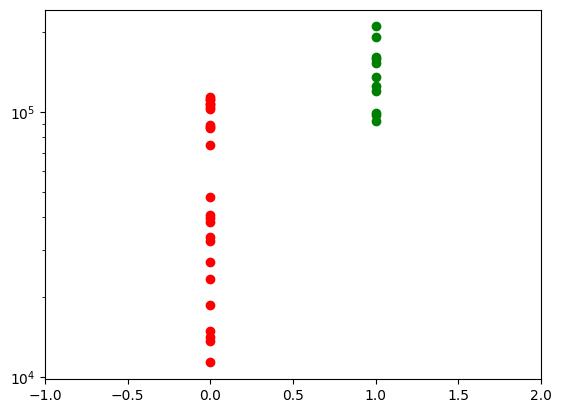

In [367]:
# gcid = gcid_lst[9]
gcid = gcid_lst[106]

smass = []
dmass = []
stform = []
dtform = []
sfeh = []
dfeh = []
dtdis = []
stieg = []
for it_id in gcid_dict[gcid]["s"]:
    src_dat = ghost_data[it_id]["source"]
    gcidx = np.where(src_dat["gcid"][()] == gcid)[0][0]
    smass.append(10 ** src_dat["logm_tfor"][gcidx])
    stform.append(src_dat["snap_tforp"][gcidx])
    sfeh.append(src_dat["feh"][gcidx])
    stieg.append(src_dat["tideig.avg"][gcidx])

for it_id in gcid_dict[gcid]["d"]:
    src_dat = ghost_data[it_id]["source"]
    gcidx = np.where(src_dat["gcid"][()] == gcid)[0][0]
    dmass.append(10 ** src_dat["logm_tfor"][gcidx])
    dtform.append(src_dat["snap_tforp"][gcidx])
    dfeh.append(src_dat["feh"][gcidx])
    dtdis.append(src_dat["tdis"][gcidx])

plt.scatter([1] * len(smass), smass, c="g")
plt.scatter([0] * len(dmass), dmass, c="r")

# plt.scatter([1] * len(smass), smass, c=sfeh)
# plt.scatter([0] * len(dmass), dmass, c=dfeh)
# plt.colorbar()

# plt.scatter([1] * len(smass), smass, c="k")
# plt.scatter([0] * len(dmass), dmass, c=dtdis)
# plt.colorbar()

# plt.scatter([1] * len(smass), smass, c=stform, vmin=150, vmax=200)
# plt.scatter([0] * len(dmass), dmass, c=dtform, vmin=150, vmax=200)
# plt.colorbar()

plt.xlim(-1, 2)
plt.yscale("log")

np.log10(np.min(smass)), np.log10(np.max(dmass))

In [368]:
stform

[172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172]

In [369]:
snap = 534
snap_id = gc_utils.snapshot_name(snap)

steig = []
for it_id in gcid_dict[gcid]["s"]:
    snp_dat = ghost_data[it_id]["snapshots"][snap_id]
    gcidx = np.where(snp_dat["gcid"][()] == gcid)[0][0]
    steig.append(snp_dat["tideig"][gcidx])

steig

[563.68,
 563.68,
 563.68,
 563.68,
 563.68,
 563.68,
 563.68,
 563.68,
 563.68,
 563.68,
 563.68]

Text(0, 0.5, 'FeH')

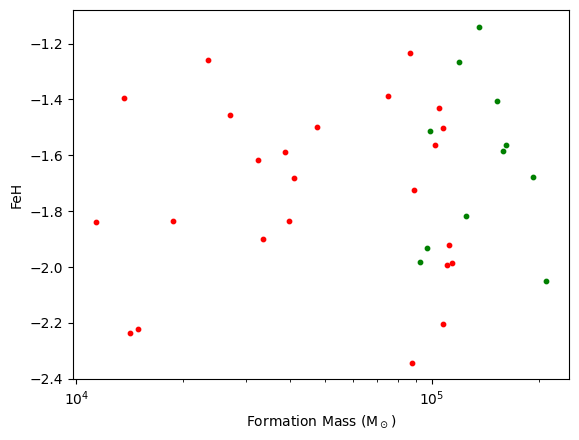

In [370]:
plt.scatter(smass, sfeh, c="g", s=10)
plt.scatter(dmass, dfeh, c="r", s=10)

plt.xscale("log")

plt.xlabel(r"Formation Mass (M$_\odot$)")
plt.ylabel(r"FeH")

In [371]:
smass = []
dmass = []
stideig = []
dtideig = []
sit_id = []
dit_id = []
for it_id in gcid_dict[gcid]["s"]:
    mas_hold = []
    tid_hold = []
    for snap_id in ghost_data[it_id]["snapshots"].keys():
        snp_dat = ghost_data[it_id]["snapshots"][snap_id]
        gcids = snp_dat["gcid"][()]
        if gcid not in gcids:
            mas_hold.append(np.nan)
            tid_hold.append(np.nan)
            continue
        gcidx = np.where(gcids == gcid)[0][0]
        mas_hold.append(10 ** snp_dat["logm"][gcidx])
        tid_hold.append(snp_dat["tideig"][gcidx])
    smass.append(mas_hold)
    stideig.append(tid_hold)
    sit_id.append(it_id)

for it_id in gcid_dict[gcid]["d"]:
    mas_hold = []
    tid_hold = []
    for snap_id in ghost_data[it_id]["snapshots"].keys():
        snp_dat = ghost_data[it_id]["snapshots"][snap_id]
        gcids = snp_dat["gcid"][()]
        if gcid not in gcids:
            mas_hold.append(np.nan)
            tid_hold.append(np.nan)
            continue
        gcidx = np.where(gcids == gcid)[0][0]
        mas_hold.append(10 ** snp_dat["logm"][gcidx])
        tid_hold.append(snp_dat["tideig"][gcidx])
    dmass.append(mas_hold)
    dtideig.append(tid_hold)
    dit_id.append(it_id)

Text(0, 0.5, 'Tideig')

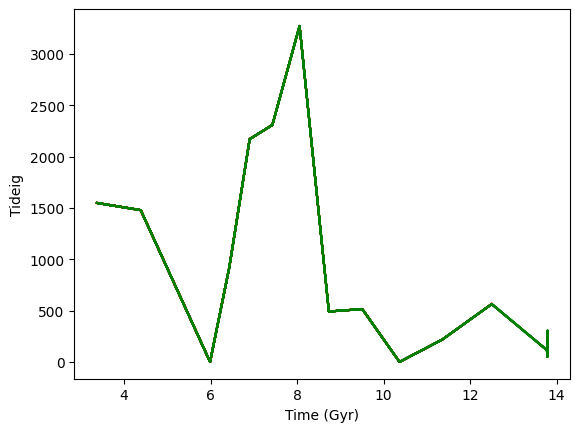

In [372]:
for tid in dtideig:
    plt.plot(tim_lst, tid, c="r")

for tid in stideig:
    plt.plot(tim_lst, tid, c="g")

# plt.yscale("log")

plt.xlabel("Time (Gyr)")
plt.ylabel("Tideig")

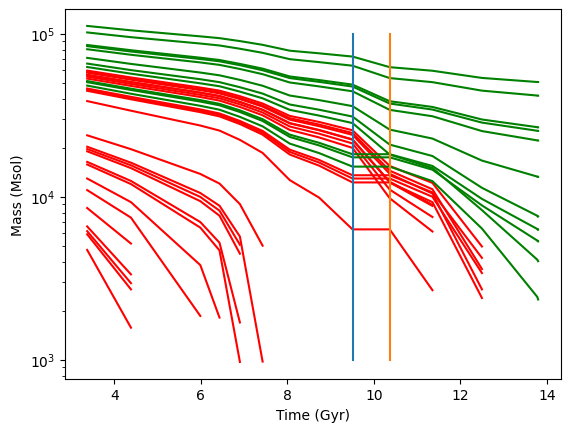

In [388]:
for mass in dmass:
    init_mass = np.array(mass)[~np.isnan(mass)][0]
    plt.plot(tim_lst, mass, c="r")

for mass in smass:
    plt.plot(tim_lst, mass, c="g")

plt.yscale("log")

plt.xlabel("Time (Gyr)")
plt.ylabel("Mass (Msol)")

snp_hld = 412  # 412, 446
tim_hld = pub_snaps[pub_snaps["index"] == snp_hld]["time_Gyr"].values
plt.plot([tim_hld, tim_hld], [10**3, 10**5])

snp_hld = 446  # 412, 446
tim_hld = pub_snaps[pub_snaps["index"] == snp_hld]["time_Gyr"].values
plt.plot([tim_hld, tim_hld], [10**3, 10**5])

Text(0, 0.5, 'Mass (Msol)')

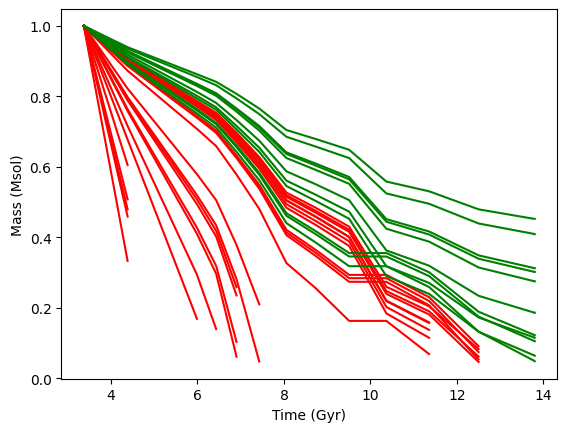

In [390]:
for mass in dmass:
    init_mass = np.array(mass)[~np.isnan(mass)][0]
    plt.plot(tim_lst, np.array(mass) / init_mass, c="r")

for mass in smass:
    init_mass = np.array(mass)[~np.isnan(mass)][0]
    plt.plot(tim_lst, np.array(mass) / init_mass, c="g")

# plt.yscale("log")

plt.xlabel("Time (Gyr)")
plt.ylabel("Mass (Msol)")

# snp_hld = 412  # 412, 446
# tim_hld = pub_snaps[pub_snaps["index"] == snp_hld]["time_Gyr"].values
# plt.plot([tim_hld, tim_hld], [10**3, 10**5])

# snp_hld = 446  # 412, 446
# tim_hld = pub_snaps[pub_snaps["index"] == snp_hld]["time_Gyr"].values
# plt.plot([tim_hld, tim_hld], [10**3, 10**5])

In [374]:
tim_lst[24], tim_lst[25]

for it_id, mass in zip(sit_id, smass):
    print("s:", it_id, mass[24], mass[25], np.log10(mass[-1]))

print("")

for it_id, mass in zip(dit_id, dmass):
    print("d:", it_id, mass[24], mass[25])

s: it013 44360.864393143274 34119.29116219288 4.345
s: it027 31045.595881283556 20892.96130854041 3.879
s: it030 15310.874616820287 15310.874616820287 3.37
s: it036 63679.55209079162 53456.435939697134 4.62
s: it042 48752.8490103386 38547.835766577206 4.426
s: it047 17458.22152920504 17458.22152920504 3.726
s: it050 35974.93351557424 25822.601906345957 4.122
s: it065 72443.59600749906 62373.483548241915 4.704
s: it078 18238.957023196384 18238.957023196384 3.798
s: it085 47424.198526024484 37325.015779572066 4.404
s: it090 28313.91995799379 18155.15662773137 3.605

d: it004 13551.89412351035 13551.89412351035
d: it005 nan nan
d: it007 nan nan
d: it009 6309.57344480193 6309.57344480193
d: it014 nan nan
d: it019 nan nan
d: it021 19952.62314968879 9794.89985408699
d: it029 21232.444620002192 11066.237839776653
d: it031 nan nan
d: it032 nan nan
d: it037 nan nan
d: it040 12941.958414499863 12941.958414499863
d: it043 nan nan
d: it054 nan nan
d: it063 22387.21138568338 12246.16199265049
d: it

In [375]:
gcid

37131255